## Bayesian Optimisation Verification

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

## Trial on TiOx/SiOx
Tempeature vs. S10_HF

In [4]:
address = 'data/Data_SOLMAT.xlsx'
df = pd.read_excel(address,sheet_name = 'Trial',usecols = [0],names = None, nrows = 6)
df_li_Temp = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'Trial',usecols = [1],names = None, nrows = 6)
df_li_s_HF = df.values.tolist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


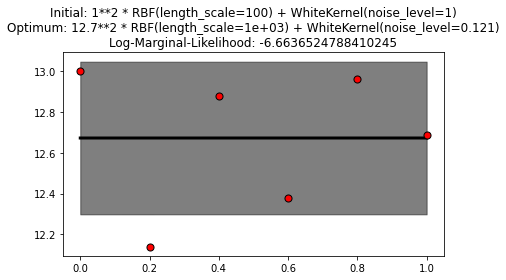

In [5]:
X = np.array(df_li_Temp)
y = np.array(df_li_s_HF).T
y = y.reshape(6)
rng = np.random.RandomState(0)
# First run
plt.figure()
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
X_ = np.linspace(0, 1, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

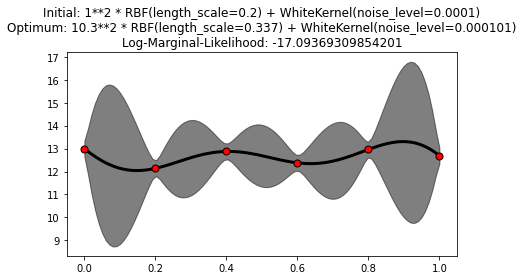

In [6]:
# Second run
plt.figure()
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
X_ = np.linspace(0, 1, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - 24*np.sqrt(np.diag(y_cov)),y_mean + 24*np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

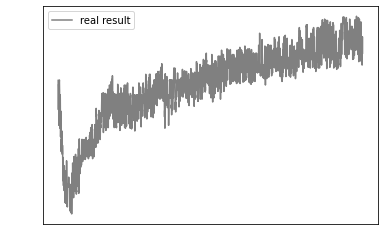

In [7]:
#import smooth data sheet at 120 C (time:0~5000s)
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [0],names = None,nrows = 5000)
df_li_Time_smooth = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_li_L_smooth = df.values.tolist()
#plot the data
plt.figure()
plt.plot(df_li_Time_smooth,df_li_L_smooth,'-',color = 'gray')
plt.legend(['real result'])
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.show()

In [8]:
#import normal data sheet at 120 C (time:0~5000s) 
address = 'data/degradation.xlsx'
x_normal = []
y_normal = []
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_li_Time = df.values.tolist()
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_li_L = df.values.tolist() 

In [46]:
# randomly select 7 points from normal data
x_normal = np.array(df_li_Time).T
y_normal = np.array(df_li_L).T 
x_normal = x_normal.reshape((5000))
y_normal = y_normal.reshape((5000))
x_random = []
y_random = []
x_random = x_normal[[1,99,999,1999,2999,3999,4999]]
y_random = y_normal[[1,99,999,1999,2999,3999,4999]]

In [10]:
#iterate 10 times with mins value point of each curvle
x_cycle = []
y_cycle = []
x_loop = x_random
y_loop = y_random
list_x_loop = x_loop.tolist()
list_y_loop = y_loop.tolist()
i=0
# can change i to control how many extra data point you would like
while i <6:
    #get the function of spline regression with known data points
    s = interpolate.InterpolatedUnivariateSpline(list_x_loop,list_y_loop)
    x_uni = np.arange(0,5000,1)
    y_uni = s(x_uni) # get all the y value  (0~5000) based on the regession function
    
    
    ## iteration 
    list_y_uni = y_uni .tolist()
    list_y_uni_max_list = min(list_y_uni) #get the maxium value
    index = list_y_uni.index(min(list_y_uni)) # get the index of maxium value
    # add the min value of the function to the next loop list
    # extra layer of protection to stop equal x value to cause increasing error
    if index in x_cycle:
        index += 1
    x_cycle.append(x_normal[index]) 
    y_cycle.append(y_normal[index])
    # list_x_loop.extend(x_cycle)
    # list_y_loop.extend(y_cycle)
    list_x_loop.append(x_cycle.pop(0))
    list_y_loop.append(y_cycle.pop(0))
    # zip to sort both list
    list_loop =sorted(zip(list_x_loop,list_y_loop))
    # unzip(no really) and get each list from the zipped list
    list_x_loop = [x for x,y in list_loop]
    list_y_loop = [y for x,y in list_loop]
    i += 1

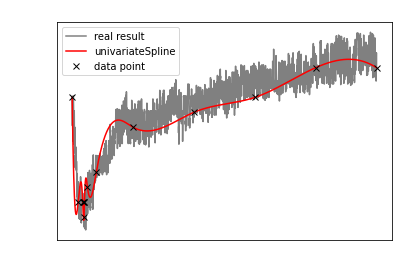

In [11]:
    #plot figure
    plt.plot(df_li_Time_smooth,df_li_L_smooth,'-',color = 'gray')
    plt.plot(x_uni,y_uni,'-',color = 'red')
    plt.plot(list_x_loop,  list_y_loop,'x',color = 'black')
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('cycle %d'%(i+1), color = 'white')
    plt.legend(['real result','univariateSpline','data point'])
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


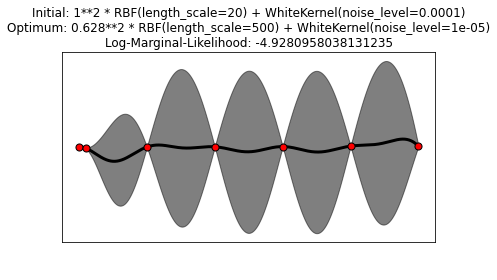

In [43]:
X = x_normal[[1,99,999,1999,2999,3999,4999]].reshape(7)
y = y_normal[[1,99,999,1999,2999,3999,4999]]
X = X.reshape(7,1)

# First run
plt.figure()
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(1e-2, 5e2)) \
    + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5000,5000)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

In [13]:
def ucb(X , gp, dim, delta):
    """
    Calculates the GP-UCB acquisition function values
    Inputs: gp: The Gaussian process, also contains all data
            x:The point at which to evaluate the acquisition function 
    Output: acq_value: The value of the aquisition function at point x
    """
    mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
    #var.flags['WRITEABLE']=True
    #var[var<1e-10]=0 
    mean = np.atleast_2d(mean).T
    var = np.atleast_2d(var).T  
    beta = 2*np.log(np.power(5000,2.1)*np.square(math.pi)/(3*delta))
    return mean + np.sqrt(beta)* np.sqrt(np.diag(var))

acp_value = ucb(X_, gp, 0.1, 5)
print(acp_value)


[[0.77260972 0.77249378 0.77241154 ... 0.77356064 0.77261435 0.77356244]
 [0.77261466 0.77249872 0.77241648 ... 0.77356558 0.77261929 0.77356738]
 [0.77261787 0.77250193 0.77241969 ... 0.77356879 0.7726225  0.77357059]
 ...
 [0.77494471 0.77482877 0.77474653 ... 0.77589563 0.77494934 0.77589743]
 [0.77463124 0.77451529 0.77443306 ... 0.77558215 0.77463586 0.77558396]
 [0.77431603 0.77420009 0.77411785 ... 0.77526695 0.77432066 0.77526876]]


In [50]:
def plot (X_,y_mean,y,y_cov,gp,kernel):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s" % (kernel, gp.kernel_,
                gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.tight_layout()

In [48]:
############################################################################
# Block of code to add 1 data point from max upper bound from plotted graph
x_loop = x_random
# Add the x value at the highest y value in y upper bound
y_upper_bound = y_mean + np.sqrt(np.diag(y_cov))
y_max = y_upper_bound.max()
x_max, =np.where(y_upper_bound == y_max)
x_loop = np.append(x_loop,x_max)
x_loop.sort()
print (x_loop)

[   1   99  999 1999 2999 3999 4522 4999]


In [32]:
x_loop =np.array([1, 10, 32, 100, 316, 1000, 3162])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


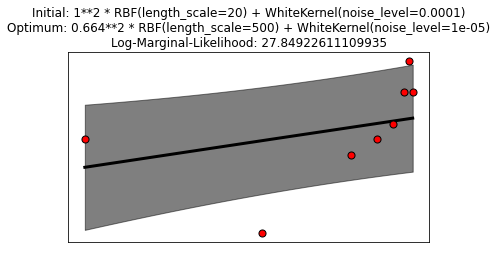

In [55]:
# Preparing training set
X = x_normal[x_loop].reshape(x_loop.size)
y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X = np.log10(X)
MAX_x_value = np.log10(5000)
X_ = np.linspace(0,MAX_x_value, 5000)
# Kernel setting
length_scale_bounds_MAX = 500
length_scale_bounds_MIN = 1e-2

kernel = 1.0 * RBF(length_scale=20,
length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) \
    + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)

y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plot (X_,y_mean,y,y_cov,gp,kernel)
